# PostNauka. Building Topic Model

Here we are going to build an experiment using cubes: there will be two stages, and after each one we will explore some properties of the trained models (also with the help of [viewers](https://github.com/machine-intelligence-laboratory/TopicNet/tree/master/topicnet/viewers)).

# Contents<a id="contents"></a>

* [Data loading and filtering](#data-preparation)
* [Constructing simple ARTM Model](#artm-model)
* [Root TopicModel and Experiment](#topic-model)
* [Exploring trained models (plots)](#exploring-models)
* [Exploring best model (viewers)](#exploring-best)
* [Improving document-topic distribution](#improving-distribution)
* [Exploring best model (after refining the experiment)](#exploring-best2)

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import cm

In [3]:
from IPython.display import display_html, display

In [5]:
import artm

from topicnet.cooking_machine import Dataset
from topicnet.cooking_machine.cubes import (
    CubeCreator,
    GreedyStrategy,
    PerplexityStrategy,
    RegularizersModifierCube,
)
from topicnet.cooking_machine.dataset import get_modality_vw
from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.model_constructor import init_simple_default_model
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.pretty_output import make_notebook_pretty
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
from topicnet.viewers.top_tokens_viewer import TopTokensViewer
from topicnet.dataset_manager import load_dataset

In [7]:
make_notebook_pretty()

## Data loading and filtering<a id="data-preparation"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Let's load a dataset with some [postnauka](https://postnauka.ru/) articles.

In [6]:
demo_data = load_dataset('postnauka')

100%|██████████| 5.55M/5.55M [00:00<00:00, 34.5MiB/s]


Dictionary filtering helps to throw out too rare or too frequent words

In [8]:
demo_data._cached_dict = demo_data.get_dictionary().filter(
    min_df=5.0, min_tf=5.0, max_df_rate=0.95
)

In [9]:
print(demo_data.get_possible_modalities())

demo_data.get_dataset().head()

{'@title', '@word', '@author', '@3gramm', '@2gramm', '@snippet', '@post_tag'}


,id,vw_text,raw_text
id,,,
1.txt,1.txt,1.txt |@author fuchs preobrazhensky tabachniko...,@title Автограф # «Математический дивертисмент...
2.txt,2.txt,2.txt |@word книга:2 лекция:3 рассматриваться:...,@title Главы: Маскулинности в российском конте...
3.txt,3.txt,3.txt |@word развитие появляться пиджина:4 бел...,@title Пиджины и креольские языки | @snippet Л...
4.txt,4.txt,4.txt |@word стандартный задача:3 состоять:4 р...,@title FAQ: Физиология микроводорослей | @snip...
5.txt,5.txt,5.txt |@2gramm повседневный_практика государст...,@title Русская государственная идеология | @sn...


## Constructing simple ARTM Model<a id="artm-model"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

TopicNet's model is basically a wrapper for BigARTM's model.
So, let's create some simple ARTM model here first.

In [ ]:
model_artm = init_simple_default_model(
    dataset=demo_data,
    modalities_to_use={'@word': 1.0, '@2gramm': 0.5, '@3gramm': 0.5, '@post_tag': 0.5},
    main_modality='@word',
    specific_topics=15,
    background_topics=1,
)

In [7]:
model_artm.class_ids  # i.e. modalities

{'@word': 1.0,
 '@2gramm': 8.796286296359932,
 '@3gramm': 246.98104755341143,
 '@post_tag': 84.10455292184933}

In [8]:
print(model_artm.regularizers)
print(model_artm.scores)

[smooth_phi_bcg, smooth_theta_bcg]
[PerplexityScore@all, SparsityThetaScore, SparsityPhiScore@word, PerplexityScore@word, TopicKernel@word, SparsityPhiScore@2gramm, PerplexityScore@2gramm, TopicKernel@2gramm, SparsityPhiScore@3gramm, PerplexityScore@3gramm, TopicKernel@3gramm, SparsityPhiScore@post_tag, PerplexityScore@post_tag, TopicKernel@post_tag]


## Root TopicModel and Experiment<a id="topic-model"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

And here is an actual topic model:

In [10]:
tm = TopicModel(model_artm)

In [11]:
specific_topics = [t for t in tm.topic_names if "background" not in t]

Experiment handles topic models: eg. training, saving.

In [12]:
experiment = Experiment(
    experiment_id="psci_experiment", save_path="experiments", topic_model=tm
)

One cube is a basic training stage:

In [ ]:
my_first_cube = RegularizersModifierCube(
    num_iter=10,
    regularizer_parameters=[
        {
            'regularizer': artm.DecorrelatorPhiRegularizer(
                name='decorrelation_phi', 
                class_ids="@word", 
                topic_names=specific_topics
            ),
            'tau_grid': [0, 0.005, 0.01, 0.015, 0.02, 0.025]
        },
        {
            'regularizer': artm.SmoothSparsePhiRegularizer(
                name="smsp_phi_specific",
                class_ids="@word", 
                topic_names=specific_topics
            ),
            'tau_grid': [-0.05, 0, 0.05]
        },
        {
            'name': "smooth_phi_bcg",
            'tau_grid': [0.1]
        },
    ],
    verbose=True
)

my_first_cube(tm, demo_data)

Let's look at the experiment now:

In [16]:
experiment.show()

Experiment psci_experiment

Experiment was made with BigARTM 0.9.0
Tree:
                                ┌##17h48m55s_18d10m2019y###
                                ├##17h49m09s_18d10m2019y###
                                ├##17h49m23s_18d10m2019y###
                                ├##17h49m36s_18d10m2019y###
                                ├##17h49m51s_18d10m2019y###
                                ├##17h50m04s_18d10m2019y###
                                ├##17h50m18s_18d10m2019y###
                                ├##17h50m32s_18d10m2019y###
                                ├##17h50m46s_18d10m2019y###
<<<<<<<<<<<root>>>>>>>>>>>──────┤
                                ├##17h50m59s_18d10m2019y###
                                ├##17h51m14s_18d10m2019y###
                                ├##17h51m27s_18d10m2019y###
                                ├##17h51m41s_18d10m2019y###
                                ├##17h51m55s_18d10m2019y###
                                ├##17h52m09s_18d10m20

## Exploring trained models (plots)<a id="exploring-models"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Perplexity for different models:

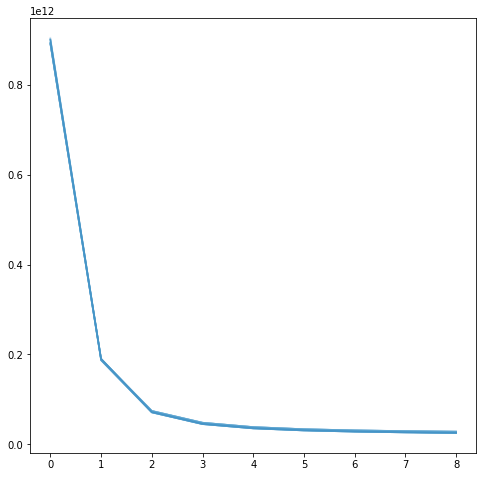

In [17]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))

for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['PerplexityScore@all']
    plt.plot(score[1:], color=cm.Blues(colors[i]))

plt.show()

Visualizing more topic scores:

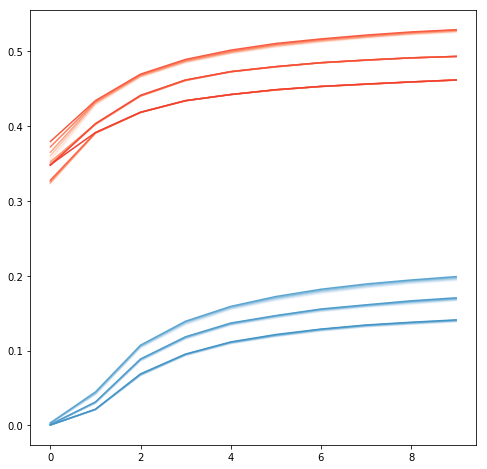

In [18]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))

for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['TopicKernel@word.average_purity']
    plt.plot(score, color=cm.Blues(colors[i]))
    score = tm.scores['TopicKernel@word.average_contrast']
    plt.plot(score, color=cm.Reds(colors[i]))

plt.show()

We can use a simple query language to select models, satisfying some criterion:

In [25]:
query = "TopicKernel@word.average_contrast -> max and PerplexityScore@all < 1.1 * MINIMUM(PerplexityScore@all)"
models = experiment.select(query + " COLLECT all")

print(len(models))

12


And another example:

In [28]:
query = (
    "TopicKernel@word.average_contrast > 0.8 * MAXIMUM(TopicKernel@word.average_contrast) "
    "and TopicKernel@word.average_purity > 0.8 * MAXIMUM(TopicKernel@word.average_purity) "
    "and PerplexityScore@all < 1.1 * MINIMUM(PerplexityScore@all) "
)
models = experiment.select(query)


models = experiment.select(query + " COLLECT all")

print(len(models))

6


In [29]:
for model in models:
    model.describe_regularizers()
    model.describe_scores()

smooth_phi_bcg 0.1
smooth_theta_bcg 0.0
decorrelation_phi 0
smsp_phi_specific 0.0
25313538048.0
0.4932064712047577
0.1664646863937378
------
smooth_phi_bcg 0.1
smooth_theta_bcg 0.0
decorrelation_phi 0.005
smsp_phi_specific 0.0
25312024576.0
0.49317318201065063
0.1672022044658661
------
smooth_phi_bcg 0.1
smooth_theta_bcg 0.0
decorrelation_phi 0.01
smsp_phi_specific 0.0
25311625216.0
0.49313482642173767
0.16795437037944794
------
smooth_phi_bcg 0.1
smooth_theta_bcg 0.0
decorrelation_phi 0.015
smsp_phi_specific 0.0
25312380928.0
0.4931844472885132
0.1685832291841507
------
smooth_phi_bcg 0.1
smooth_theta_bcg 0.0
decorrelation_phi 0.02
smsp_phi_specific 0.0
25314265088.0
0.4932193160057068
0.16932210326194763
------
smooth_phi_bcg 0.1
smooth_theta_bcg 0.0
decorrelation_phi 0.025
smsp_phi_specific 0.0
25317392384.0
0.493261456489563
0.17049165070056915
------


Looks like SmoothSparsePhiRegularizer was redundant. There's a clear winner: `decorrelation_phi 0.025`, but we'll take everything.

## Exploring best model (viewers)<a id="exploring-best"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [32]:
best_model = models[-1]

TopicNet's [viewers](https://github.com/machine-intelligence-laboratory/TopicNet/tree/master/topicnet/viewers) help to look at topic models.

In [33]:
thresh = 1e-5
first_model_top_tok = TopTokensViewer(best_model, num_top_tokens=10, method='phi')
first_model_html =  first_model_top_tok.to_html(first_model_top_tok.view(),thresh=thresh)

In [35]:
first_model_top_doc = TopDocumentsViewer(best_model, dataset=demo_data).view()

In [41]:
n=7
"""
this code is working but slightly outdated.
To produce similar results we suggest to use

token_html = first_model_top_tok.view_from_jupyter(
    display_output=False,
    give_html=True)
document_html = first_model_top_doc.view_from_jupyter(
    display_output=False, 
    give_html=True)

for t, d in zip(token_html, document_html):
    display_html(t)
    display_html(d)
    
"""

for line, topic_docs in list(zip(first_model_html, first_model_top_doc))[:n]:
    display_html(line, raw=True)

    for doc_id in topic_docs:
        doc_vw = demo_data.get_vw_document(doc_id).values[0][0]
        doc_title = get_modality_vw(doc_vw, "@title")
        doc_snippet = get_modality_vw(doc_vw, "@snippet")
        display_html(f"<b>{doc_title}</b><br />{doc_snippet}", raw=True)

,topic_0 @2gramm
нервный_клетка,0.01569
нервный_система,0.01173
головной_мозг,0.00754
орган_чувство,0.00586
нейронный_сеть,0.00537
система_отсчёт,0.00531
человеческий_мозг,0.0049
работа_мозг,0.00472
флуоресцентный_белка,0.00434
данный_момент,0.00424


зеркальные нейроны нейрофизиолог ольга сварник об активации нейронов в моторной коре, отражении чужих действий и томографии

предвнимание и внимание психолог игорь уточкин об особенностях зрительного восприятия, фокальном внимании и теории интеграции признаков

поведенческая специализация нейрона нейрофизиолог ольга сварник о фотографии дженнифер энистон, концепции мышиного гнезда и чтении действий по нейронам

молекулярные механизмы памяти нейробиолог павел балабан о процессе обучения, «молекуле памяти» и высших функциях мозга

командные нейроны нейробиолог павел балабан о сенсорных нейронах, исследованиях беспозвоночных и моделирующих клетках

нейрокоммуникаторы, нейроконтроллеры, нейропротезы, экзоскелетоны психофизиолог александр каплан о возможностях мозга, нейроинтерфейсных технологиях и экспериментах с кибернетической рукой

механизмы забывания психолог алексей созинов об активном забывании, нарушениях обучения и специализации нейронов

модели памяти в когнитивной психологии психолог мария фаликман о системах памяти, принципах хранения информации и причинах забывания

психическая травма и картина мира психолог мария падун о базисных убеждениях, картине мира младенцев и поиске новых смыслов травматического события

чем объясняются оптические иллюзии? психолог мария фаликман о процессе зрительного восприятия, обмане зрения и конкурсе на лучшую оптическую иллюзию года

,topic_1 @2gramm
нобелевский_премия,0.01135
квантовый_компьютер,0.009
длина_волна,0.00611
магнитный_поль,0.00593
квантовый_механика,0.00592
кристаллический_структура,0.00547
органический_химия,0.0049
квантовый_точка,0.00489
твёрдый_тело,0.00481
высокий_давление,0.00472


превращения в кристаллах материаловед валентин крапошин о полиморфном переходе, закалке стали и причинах плавления льда на поверхности воды

дефекты кристаллической решеткидрузья или враги? физик александр глезер о классификации дефектов кристаллической решетки, их свойствах и пользе для кристаллов

премии # нобелевская премия мира - 2013 спецпроект постнауки, посвященный нобелевской неделе и её результатам

квантовый метод монте-карло физик алексей рубцов о фейнмановской формулировке, квантовой формулировке и общей философии квантовой теории

квантовый компьютер физик владимир шалаев о скорости обработки информации, нанофотонике и квантовой запутанности

ближнепольная оптическая микроскопия физик дмитрий казанцев о ближнем оптическом поле, истории изобретения прибора для snom и детектировании света

методы предсказания кристаллических структур химик артем оганов о задачах кристаллографии, методе uspex и структуре алмаза

дизайн сверхтвердых материалов химик артем оганов о структуре алмаза, применении сверхтвердых материалов и новых формах углерода

фуллерены нобелевский лауреат по химии харольд крото о молекулярных решетках, исследовании углеродных звезд и фундаментальной науке

многомировая интерпретация квантовой физики физик александр львовский о существовании «параллельных вселенных», вероятностном коллапсе волновой функции и парадоксах квантовой механики

,topic_2 @2gramm
xx_век,0.01225
xix_век,0.01173
гражданский_война,0.00877
мировой_война,0.00711
речь_идти,0.00533
советский_власть,0.00462
русский_язык,0.00444
российский_империя,0.00348
конец_xix,0.00328
xvi_век,0.00315


современная аналитическая философия философ дмитрий иванов о венском кружке, возрождении метафизики и метаэтике

логика мифа филолог гасан гусейнов о праповествовании о мире, объяснении мироздания в мифе и отличии мифа от логоса

эрос в античной культуре филолог гасан гусейнов о происхождении эрота, слепоте любви и панк-культуре

ацтекская империя историк дмитрий беляев о тройственном союзе ацтеков, формировании империи в теночтитлане и военно-религиозной идеологии

россия и казацкая украина историк кирилл кочегаров об истории запорожской сечи, восстании богдана хмельницкого и угасании казацкой автономии

особенности либерализма в россии историк кирилл соловьев о первых русских либералах, поддержке самодержавия и политической программе кадетов

миф и архитектура филолог гасан гусейнов о мифологическом измерении архитектуры, ахиллесовой пяте и изоморфизме строений и человеческого тела

5 книг об античной мифологии что читать о греческих и римских мифах, рекомендует доктор филологических наук гасан гусейнов

древнегреческие мифы о душе филолог гасан гусейнов о создании первых людей, свойствах души и ящике пандоры

faqэрос в античной культуре 7 фактов об одном из самых загадочных персонажей греческой мифологии

,topic_3 @2gramm
римский_право,0.01183
мировой_война,0.01113
католический_церковь,0.00789
xvii_век,0.00696
право_собственность,0.00626
речь_идти,0.00599
научный_революция,0.00511
дать_случай,0.00508
крайний_мера,0.00485
веймарский_республика,0.00479


римское право 12 лекций о правовой системе древнего рима, отобранных историком права александром мареем

веймарская республика историк илья женин о республике без республиканцев, октябрьской революции и социал-демократической партии

обязательства юрист дмитрий дождев о праве на действия, трактовке фридриха савиньи и договоре как главном агенте

лица историк александр марей о положении раба, правах вольноотпущенников и статусе гражданина рима

купля-продажа юрист дмитрий дождев о взаимном обязательстве, конструкции обеспечительного задатка и риске покупателя

европейская традиция частного права 12 лекций юриста дмитрия дождева о римских истоках современного права

сервитуты юрист дмитрий дождев об использовании благ соседнего участка, вещных правах и условиях установления сервитутов

контракты юрист дмитрий дождев о договорных типах в римском праве, исковой защите и свободе договора

добросовестность юрист дмитрий дождев о критике понятия, свободе усмотрения и римском праве

залог юрист дмитрий дождев о праве следования, обеспечительной функции залога и предмете залогового права

,topic_4 @2gramm
русский_язык,0.04297
английский_язык,0.00779
разный_язык,0.00695
литературный_язык,0.00684
носитель_язык,0.00642
дискурсивный_слово,0.0059
устный_речь,0.00554
индоевропейский_язык,0.00539
человеческий_язык,0.00495
языковой_семья,0.00493


мотивированность языковой формы лингвист мира бергельсон о прагматике языка, структуре делового письма и стратегиях вежливости

соотношение понятий язык и диалект лингвист владимир беликов о взаимопонятности внутри языка, издании ethnologue и сербохорватском языке

языковые макросемьи лингвист георгий старостин о языковых семьях, термине "ностратика" и гипотезах объединения языков

методы полевой лингвистики лингвист нина сумбатова о научной этике, методе элицитации и анализе текстов

русская аспектология лингвист алексей шмелев о глаголах совершенного и несовершенного вида, видовых парах и аспектологическом словаре

пиджины и креольские языки лингвист владимир беликов о языке-лексификаторе, креолизации и языках новой гвинеи

лингвистическая компаративистика лингвист светлана бурлак о системности изменений в языках, языковом древе и реконструкции праязыка

гласные русского языка лингвист игорь исаев об истории гласных в литературном языке, следах утраченных букв и особенностях говоров

понимание культуры через язык лингвист алексей шмелев о восприятии материальной культуры в речи, отличии лжи от вранья и трудностях перевода

ударение на предлог филолог илья иткин о русской поэзии, системе ударений и языковой традиции

,topic_5 @2gramm
политический_философия,0.00879
мировой_война,0.00673
речь_идти,0.00651
советский_союз,0.00597
политика_память,0.00522
малое_город,0.00479
крайний_мера,0.00463
городской_пространство,0.0041
xx_век,0.00383
обычный_право,0.00302


вернакулярный город урбанист александр высоковский о драме самоочевидности, понятии вернакуляра и архитектуре без архитектора

тирания у ксенофонта философ александр павлов о диалоге «гиерон», философии ксенофонта в работах лео штрауса и проекте добродетельной тирании

позитивная философия науки философ иван болдырев о необходимости анализа, задачах исследования науки и ошибках социологии науки

философия всеединства философ алексей козырев о религиозных идеях владимира соловьева, учении о сверхбытии и московской школе философии права

тирания у платона философ александр павлов о политической философии платона, понимании тирании в диалогах «государство» и «законы» и идеальном политическом режиме

понятие идеологии социолог культуры арсений хитров о придворном философе наполеона i, критике капитализма у маркса и конструкте «человеческая природа»

гегель сегодня философ иван болдырев об исследователях гегелевской философии, аналитической теории действия и консерватизме

прикладная геоурбанистика урбанист екатерина ларионова об исчезновении самоидентичности городов, культуре санкт-петербурга и естественном образе жизни человека

ироническая эстетика зольгера философ иван болдырев о диалектической традиции, философских диалогах и ситуации иронии

развитие городов географ наталья зубаревич о процессе субурбанизации, агломерационном эффекте и необходимости децентрализации

,topic_6 @2gramm
живой_организм,0.00876
естественный_отбор,0.0063
нитрид_бора,0.00577
органический_вещество,0.00522
половый_отбор,0.00457
живой_существо,0.00444
простой_число,0.00403
пермский_период,0.00396
поведение_животное,0.00395
творческий_мышление,0.00386


пермский период палеоботаник сергей наугольных о возникновении пермской системы, эпохе высокого стояния континентов и пермо-триасовом вымирании видов

палеофитоценоз палеоботаник сергей наугольных о реконструкции раннепермской растительности, переходе к филоценогенетике и ориктоценозе

палеоботаника палеоботаник сергей наугольных об истории дисциплины, главных открытиях и ее связи с палеозоологией

физиология микроводорослей биолог дмитрий лось о видовом разнообразии, очистке воздуха для космических полетов и полиненасыщенных жирных кислотах

faqпермский период 7 фактов о периодизации пермской геологической системы

янтарь как палеонтологический объект палеонтолог кирилл еськов о палеонтологической летописи, балтийском янтаре и лесной фауне

«многие юрские животные продолжили свое развитие и даже имеют потомков в наше время» палеонтолог чжунхэ чжоу о многообразии удивительных животных юрского периода

архейская эра биолог александр марков о поздней тяжелой бомбардировке, древнейших следах жизни на земле и бескислородном периоде

5 книг о палеоботанике пермского периода что читать об ископаемых растениях пермского периода, рекомендует доктор геолого-минералогических наук сергей наугольных

микробы докембрия микробиолог зоригто намсараев об условиях докембрийского периода, микробных матах и теории первичного бульона

In [43]:
display_html(first_model_html[-1], raw=True)
    
topic_docs = first_model_top_doc[-1]
topic_docs = [str(topic) for topic in topic_docs]

for doc_id in topic_docs:
        doc_vw = demo_data.get_vw_document(doc_id).values[0][0]
        doc_title = get_modality_vw(doc_vw, "@title")
        doc_snippet = get_modality_vw(doc_vw, "@snippet")
        display_html(f"<b>{doc_title}</b><br />{doc_snippet}", raw=True)

,background_15 @2gramm
система_образование,0.00657
средний_класс,0.00488
xx_век,0.00427
xix_век,0.00415
язык_описание,0.00411
дать_случай,0.00384
огромный_количество,0.00378
новый_программа,0.00355
среднее_класс,0.00354
научный_сообщество,0.00322


эпос как фольклорный жанр фольклорист сергей неклюдов о живом эпосе, технике сказительства и образе богатыря

аксиоматический метод математик лев беклемишев о неевклидовой геометрии, системе аксиом гильберта и смысле в математике

компьютерные доказательства математик лев беклемишев о теории множеств, интерактивных системах и проблеме о четырех красок

теорема семереди математик илья шкредов о гипотезе эрдеша — турана об арифметических прогрессиях, теории графов и рождении новой науки

как написать диссертацию историк андрей зорин о правильном заголовке, составлении плана и подготовке к устной защите

машина тьюринга математик александр шень об идее универсальной машины, проблеме перебора и случайности

премии # филдсовская премия - 2014 математики сергей ландо и александр буфетов о важности присуждения премии мариам мирзахани, ее вкладе в современную науку и «случайной геометрии»

точка зрения # нужны ли экзамены в высшем образовании мнения экспертов постнауки об эффективности традиционной формы проверки знаний

точка зрения # профсоюз ученых мнения экспертов постнауки о том, как ученые должны защищать свои интересы

точка зрения # зачем нужен «список вак» и когда его отменят? мнения экспертов постнауки о публикациях в «ваковских журналах» и получении научной степени

## Improving document-topic distribution<a id="improving-distribution"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

We will use another cube for this:

In [ ]:
theta_cube = RegularizersModifierCube(
    num_iter=10,
    regularizer_parameters=[
        {
            'regularizer': artm.SmoothSparseThetaRegularizer(name="smsp_theta_specific",
                                                           topic_names=specific_topics),
            'tau_grid': [-0.05, -0.01, 0]
        },
        {
            'name': "smooth_theta_bcg",
            'tau_grid': [0.01, 0.1]
        },
    ],
    verbose=True
)

theta_cube(models, demo_data)

In [44]:
experiment.show()

Experiment psci_experiment

Experiment was made with BigARTM 0.9.0
Tree:
                                ┌##17h48m55s_18d10m2019y###
                                │                                                            ┌##18h10m55s_18d10m2019y###
                                │                                                            ├##18h11m11s_18d10m2019y###
                                │                                                            ├##18h11m26s_18d10m2019y###
                                ├##17h49m09s_18d10m2019y###──────────────────────────────────┤
                                │                                                            ├##18h11m42s_18d10m2019y###
                                │                                                            ├##18h11m57s_18d10m2019y###
                                │                                                            └##18h12m12s_18d10m2019y###
                                ├##17h49m23s_1

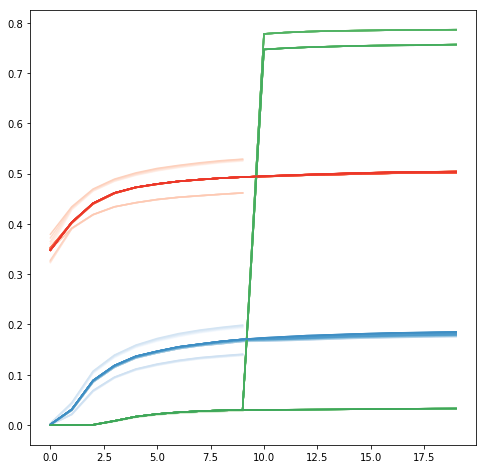

In [46]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))

for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['TopicKernel@word.average_purity']
    plt.plot(score, color=cm.Blues(colors[i]))
    
    score = tm.scores['TopicKernel@word.average_contrast']
    plt.plot(score, color=cm.Reds(colors[i]))
    
    score = tm.scores['SparsityThetaScore']
    plt.plot(score, color=cm.Greens(colors[i]))

plt.show()

In [51]:
query = (
    "TopicKernel@word.average_contrast > 0.95 * MAXIMUM(TopicKernel@word.average_contrast) "
    "and PerplexityScore@all < 1.1 * MINIMUM(PerplexityScore@all) "
    "and SparsityThetaScore > MEDIAN(SparsityThetaScore) "
    "and TopicKernel@word.average_purity -> max "
    "COLLECT 3"
)
models = experiment.select(query)

len(models)

3

In [52]:
for model in models:
    describe_model(model)

smooth_phi_bcg 0.1
smooth_theta_bcg 0.1
decorrelation_phi 0.02
smsp_phi_specific 0.0
smsp_theta_specific -1.1118567555933032
20892270592.0
0.503779947757721
0.18242311477661133
------
smooth_phi_bcg 0.1
smooth_theta_bcg 0.1
decorrelation_phi 0.015
smsp_phi_specific 0.0
smsp_theta_specific -1.1118567555933032
20889540608.0
0.5037607550621033
0.18155907094478607
------
smooth_phi_bcg 0.1
smooth_theta_bcg 0.1
decorrelation_phi 0.01
smsp_phi_specific 0.0
smsp_theta_specific -1.1118567555933032
20887879680.0
0.503887951374054
0.18075668811798096
------


## Exploring best model (after refining the experiment)<a id="exploring-best2"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [53]:
best_model = models[0]

In [54]:
first_model_top_tok = TopTokensViewer(best_model, num_top_tokens=10, method='phi')
first_model_html =  first_model_top_tok.to_html(first_model_top_tok.view(),thresh=thresh)
first_model_top_doc = TopDocumentsViewer(best_model, dataset=demo_data).view()

In [57]:
n=5

for line, topic_docs in list(zip(first_model_html, first_model_top_doc))[:n]:
    display_html(line, raw=True)

    for doc_id in topic_docs:
        doc_vw = demo_data.get_vw_document(doc_id).values[0][0]
        doc_title = get_modality_vw(doc_vw, "@title")
        doc_snippet = get_modality_vw(doc_vw, "@snippet")
        display_html(f"<b>{doc_title}</b><br />{doc_snippet}", raw=True)

,topic_0 @2gramm
нервный_клетка,0.01427
нервный_система,0.01096
головной_мозг,0.00863
орган_чувство,0.00543
человеческий_мозг,0.00523
когнитивный_психология,0.00521
система_отсчёт,0.00493
работа_мозг,0.00473
решение_задача,0.00467
данный_момент,0.00401


страхпричины, механизмы и рефлексы 5 фактов о физиологических основаниях и исследованиях страха

модели памяти в когнитивной психологии психолог мария фаликман о системах памяти, принципах хранения информации и причинах забывания

faqзеркальные нейроны 7 фактов о нейронах, активность которых отображает чужие действия

faqнейрогибридные системы 7 фактов об изучении нейронов в чашке петри

faqкомандные нейроны 5 фактов о различных функциях клеток в нервной системе

клеточные следы сознания в мозге нейробиолог константин анохин об исследованиях субъективного опыта, эпизодической памяти у животных и активности клеток в момент запоминания

зрительное внимание психолог мария фаликман о функции отбора, прожекторе внимания и теории интеграции признаков

физиология радости физиолог павел умрюхин о последствиях эмоционального стресса, оптимуме мотивации и потребности в творчестве

проблема сознания и мозга нейробиолог константин анохин о коре головного мозга, изучении нервных коррелятов сознания и коматозных состояниях

молекулярные механизмы памяти нейробиолог павел балабан о процессе обучения, «молекуле памяти» и высших функциях мозга

,topic_1 @2gramm
нобелевский_премия,0.01005
квантовый_компьютер,0.00837
магнитный_поль,0.00682
длина_волна,0.00617
магнитный_пол,0.00531
органический_химия,0.00514
кристаллический_структура,0.00498
твёрдый_тело,0.00475
квантовый_механика,0.00471
высокий_давление,0.00458


технология охлаждения атомов физик владимир мележик о волновых свойствах частиц, лазерном охлаждении и системах пониженной размерности

методы предсказания кристаллических структур химик артем оганов о задачах кристаллографии, методе uspex и структуре алмаза

дизайн сверхтвердых материалов химик артем оганов о структуре алмаза, применении сверхтвердых материалов и новых формах углерода

sciencehub #01квантовая криптография физик александр львовский о создании квантового повторителя, безопасной передаче информации и коммерциализации квантовых разработок

faqквантовый метод монте-карло 5 фактов о траекториях частиц, симуляциях на квантовом компьютере и возникновении сложности

применение графена физик сергей морозов о свойствах графена, новых типах жидкокристаллических дисплеев и цифровой электронике

специфика нанотехнологий физик алексей акимов об уникальных свойствах нанообъектов, создании новых материалов и управлении светом

faqграфен 5 фактов о новой форме углерода и перспективах ее применения

дизайн новых материалов 10 лекций химика артема оганова о современных исследовательских подходах в химии и материаловедении

когда квантовые компьютеры будут доступны для всех? физик александр львовский о расшифровке криптографических кодов, размере транзисторов и ведении информационной войны

,topic_2 @2gramm
xx_век,0.01228
xix_век,0.01205
гражданский_война,0.00759
мировой_война,0.0065
речь_идти,0.00564
русский_язык,0.0045
xviii_век,0.00357
российский_империя,0.00354
советский_власть,0.0035
конец_xix,0.00343


ацтекская империя историк дмитрий беляев о тройственном союзе ацтеков, формировании империи в теночтитлане и военно-религиозной идеологии

особенности либерализма в россии историк кирилл соловьев о первых русских либералах, поддержке самодержавия и политической программе кадетов

faqэрос в античной культуре 7 фактов об одном из самых загадочных персонажей греческой мифологии

современная аналитическая философия философ дмитрий иванов о венском кружке, возрождении метафизики и метаэтике

россия и казацкая украина историк кирилл кочегаров об истории запорожской сечи, восстании богдана хмельницкого и угасании казацкой автономии

логика мифа филолог гасан гусейнов о праповествовании о мире, объяснении мироздания в мифе и отличии мифа от логоса

эрос в античной культуре филолог гасан гусейнов о происхождении эрота, слепоте любви и панк-культуре

5 книг об античной мифологии что читать о греческих и римских мифах, рекомендует доктор филологических наук гасан гусейнов

русский европеец как явление культуры историк владимир кантор о противостоянии философии западников и славянофилов, русском самосознании и критике европы

5 книг об ирландии что читать об истории и культуре ирландии, рекомендует кандидат культурологии светлана кузнецова

,topic_3 @2gramm
мировой_война,0.01432
римский_право,0.0127
xvii_век,0.00913
католический_церковь,0.00858
xviii_век,0.00821
право_собственность,0.00662
речь_идти,0.00654
дать_случай,0.00533
веймарский_республика,0.005
научный_революция,0.00488


папство и россияистория дипломатических отношений как развивались отношения москвы и святого престола и с какими проблемами им приходилось сталкиваться?

стрелецкие бунты историк александр лаврентьев о бунте 1682 года, царевне софье и утре стрелецкой казни

5 книг по истории германии в хх веке что читать об историческом развитии германии от веймарской республики до современности, рекомендует кандидат исторических наук илья женин

веймарская республика историк илья женин о республике без республиканцев, октябрьской революции и социал-демократической партии

причины французской революции историк дмитрий бовыкин об экономическом кризисе во франции накануне революции, необходимости реформ и генеральных штатах

faqдобросовестность 5 фактов об одном из важнейших наследий римского права и его современном понимании

правовые последствия смешения вещей юрист денис новак о смешении однородных вещей, праве собственности на такое имущество и кондикционном иске

римское право 12 лекций о правовой системе древнего рима, отобранных историком права александром мареем

кондикция владения юрист денис новак о защите при неправомерном лишении владения, виндикационном и кондикционном исках и ценности владения имуществом

понятие и система римского права историк александр марей об «институциях» гая, цивильном праве и ульпиане

,topic_4 @2gramm
русский_язык,0.04228
английский_язык,0.0079
литературный_язык,0.00685
разный_язык,0.00677
носитель_язык,0.0065
дискурсивный_слово,0.00591
устный_речь,0.00561
индоевропейский_язык,0.0054
человеческий_язык,0.005
языковой_семья,0.00484


«глагольный вид является едва ли не самым сложным для изучения» интервью с лингвистом алексеем шмелевым о предмете изучения аспектологии, ошибках в употреблении глаголов и сложностях русской грамматики

русский диалектный консонантизм лингвист игорь исаев о твердости/мягкости согласных, особенностях артикуляции в говорах и методах фонетического анализа речи

двувидовые глаголы лингвист александр пиперски об особенностях глаголов совершенного и несовершенного вида, интеграции в русский язык заимствованных глаголов и видовых противоречиях в русских словарях

гласные русского языка лингвист игорь исаев об истории гласных в литературном языке, следах утраченных букв и особенностях говоров

faqударение на предлог 7 фактов о системе ударений и памяти языка в поэтической традиции

германские языки лингвист александр пиперски о глагольной системе, фонетике и синтаксисе германских языков

«диалектные черты имеют глубокую историю, но до сих пор сохраняются носителями, живущими в деревнях» интервью с лингвистом игорем исаевым о диалектных особенностях северного наречия русского языка

микросинтаксис русского языка лингвист леонид иомдин об описании микросинтаксических элементов языка, грамматике конструкций и синтаксических корпусах текстов

faqдискурсивные слова 7 фактов о богатстве значений слов-паразитов

faqэволюция языка 6 фактов о языковых изменениях, причинах грамматических трансформаций и новых словах